<a href="https://colab.research.google.com/github/Rishi-128/ml4dqm-vit-classification/blob/main/ML4DQM_Test1_ViT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
!pip install timm


In [20]:
import numpy as np
import os
import urllib.request
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc
import timm
import torch.nn.functional as F

In [21]:
X1 = np.load("/content/Run355456_Dataset_jqkne.npy")
X2 = np.load("/content/Run357479_Dataset_iodic.npy")
print(X1.shape, X2.shape)


(10000, 64, 72) (10000, 64, 72)


In [22]:
y1 = np.zeros(len(X1))
y2 = np.ones(len(X2))
X = np.concatenate([X1, X2], axis=0)
y = np.concatenate([y1, y2], axis=0)
print("X:", X.shape)
print("y:", y.shape)

X: (20000, 64, 72)
y: (20000,)


In [23]:
def preprocess(X):
    X = np.log1p(X)
    X_min = X.min(axis=(1,2), keepdims=True)
    X_max = X.max(axis=(1,2), keepdims=True)
    X = (X - X_min) / (X_max - X_min + 1e-8)
    return X
X = preprocess(X)
X = X[:, None, :, :]


In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [25]:
X, _, y, _ = train_test_split(
    X, y,
    train_size=6000,
    stratify=y,
    random_state=42
)
print("After subsample:", X.shape, y.shape)

After subsample: (6000, 1, 64, 72) (6000,)


In [26]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.3,
    stratify=y,
    random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    stratify=y_temp,
    random_state=42
)


In [27]:
print("Train labels:", np.unique(y_train, return_counts=True))
print("Val labels:", np.unique(y_val, return_counts=True))
print("Test labels:", np.unique(y_test, return_counts=True))


Train labels: (array([0., 1.]), array([2100, 2100]))
Val labels: (array([0., 1.]), array([450, 450]))
Test labels: (array([0., 1.]), array([450, 450]))


In [28]:
class HCALDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        x = self.X[idx]  # (1, 64, 72)

        x = torch.nn.functional.interpolate(
            x.unsqueeze(0),
            size=(224, 224),
            mode="bilinear",
            align_corners=False
        ).squeeze(0)

        return x, self.y[idx]


In [29]:
train_ds = HCALDataset(X_train, y_train)
val_ds   = HCALDataset(X_val, y_val)
test_ds  = HCALDataset(X_test, y_test)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32)
test_loader  = DataLoader(test_ds, batch_size=32)


In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = timm.create_model(
    "vit_tiny_patch16_224",
    pretrained=False,
    in_chans=1,
    num_classes=1,
    dynamic_img_size=True
).to(device)


In [31]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

In [32]:
def train_epoch(loader):
    model.train()
    loss_sum = 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x).squeeze()
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        loss_sum += loss.item()

    return loss_sum / len(loader)


In [33]:
def eval_epoch(loader):
    model.eval()
    preds, targets = [], []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            out = torch.sigmoid(model(x).squeeze()).cpu().numpy()
            preds.extend(out)
            targets.extend(y.numpy())

    return np.array(preds), np.array(targets)


In [34]:
for epoch in range(3):
    train_loss = train_epoch(train_loader)
    val_preds, val_targets = eval_epoch(val_loader)
    val_auc = auc(*roc_curve(val_targets, val_preds)[:2])
    print(f"Epoch {epoch+1}: Loss={train_loss:.4f}, Val AUC={val_auc:.4f}")

Epoch 1: Loss=0.6958, Val AUC=0.9990
Epoch 2: Loss=0.6770, Val AUC=0.9978
Epoch 3: Loss=0.5645, Val AUC=1.0000


In [35]:
test_preds, test_targets = eval_epoch(test_loader)
test_pred_labels = (test_preds > 0.5).astype(int)
test_acc = accuracy_score(test_targets, test_pred_labels)
fpr, tpr, _ = roc_curve(test_targets, test_preds)
test_auc = auc(fpr, tpr)
print("Test Accuracy:", test_acc)
print("Test AUC:", test_auc)


Test Accuracy: 0.9966666666666667
Test AUC: 1.0


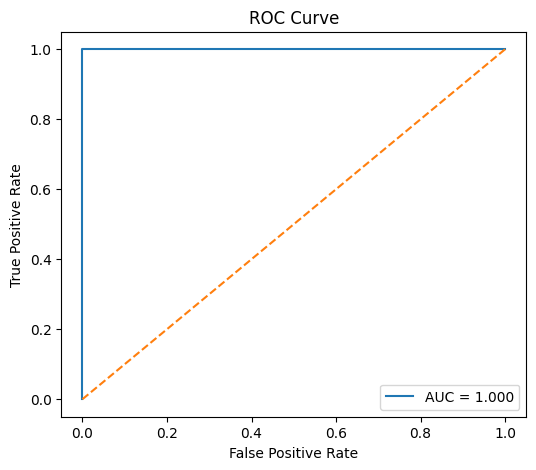

In [36]:
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {test_auc:.3f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()